# HomeWork 12

**DeadLine : 23:59 27 Azar 1399**

**Total points : 100pts**

Import some prerequisites:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import pandas as pd
import seaborn as sn
import os
import time

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Run this cell for plotting evaluation.

In [3]:
from sklearn.metrics import accuracy_score,confusion_matrix
def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy for', title, '=', acc * 100)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

# PART 3

Here is for your helper functions(optional)

In [4]:
def spiral_cw(A):
    A = np.array(A)
    out = []
    while(A.size-1):
        out.append(A[0])
        A = A[1:].T[::-1]
    return np.concatenate(out)

Classify images with HOG.

In [5]:
from skimage.feature import hog
def classify_hog(x_train, y_train, x_test):
    '''
    Classifies images with HOG.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    hog_features = []
    hog_features_test = []
    
    #Write your code here
    image = np.zeros((x_t.shape[1], x_t.shape[2]))
    for i in range(0, x_t.shape[0]):
        image = x_t[i,:,:]
        hFeature = hog(image)
        hog_features.append(hFeature)
        
    svc = LinearSVC()
    svc.fit(hog_features, y_t)
    for i in range(0, x_te.shape[0]):
        image_test = x_te[i,:,:]
        hFeature_test = hog(image_test)
        hog_features_test.append(hFeature_test)
        
    predicted_labels = svc.predict(hog_features_test)

    return predicted_labels

Classify images using shape descriptors.

In [6]:
def classify_shape_desc(x_train, y_train, x_test):
    '''
    Classifies images by using shape descriptors.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    moment = np.zeros((x_t.shape[0], 8*24))
    moment_test = np.zeros((x_te.shape[0], 8*24))
    
    #Write your code here
    for i in range(0, x_t.shape[0]):
        image = x_t[i,:,:]
        ret, thresh = cv2.threshold(image, 127, 255, 0)
        cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        image_moments = np.zeros((len(cnts), 24))
        for (ci, cnt) in enumerate(cnts):
            image_moments[ci,:] = np.array(list(cv2.moments(cnt).values()))
        moment[i, :len(cnts)*24] = image_moments.ravel()
        
    # Test:
    svc = LinearSVC()
    svc.fit(moment, y_t)
    for i in range(0, x_te.shape[0]):
        image_test = x_te[i,:,:]
        ret, thresh = cv2.threshold(image_test, 127, 255, 0)
        cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        image_moments = np.zeros((len(cnts), 24))
        for (ci, cnt) in enumerate(cnts):
            image_moments[ci,:] = np.array(list(cv2.moments(cnt).values()))
        moment_test[i, :len(cnts)*24] = image_moments.ravel()
            
    predicted_labels = svc.predict(moment_test)
    
    return predicted_labels    

Implement LBP here:

In [7]:
def LBP(img):
    '''
    Extracts LBP features from the input image.
    
    Parameters:
        img(numpy.ndarray) : image data
    outputs:
        output: LBP features
    '''
    
    input_img = img.copy()
    output = None
    
    #Write your code here
    offset = 3
    border = 1
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_REPLICATE)
    output = np.zeros((img.shape))
    for i in range(0, img.shape[0] - offset):
        for j in range(0, img.shape[1] - offset):
            codeArr = np.greater_equal(img[i:i+offset, j:j+offset], img[i+border, j+border])
            binary = spiral_cw(codeArr.astype(int))
            strings = [str(integer) for integer in binary]
            binNum = "".join(strings)
            output[i+border, j+border] = int(binNum, 2)
            
    output = output[1:-1, 1:-1]
    
    return output


Classify images using your LBP.

In [8]:
def classify_your_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using your LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    histogram = np.zeros((x_t.shape[0], 16*256))
    histogram_te = np.zeros((x_te.shape[0], 16*256))
    step = 7
    
    #Write your code here
    for i in range(0, x_t.shape[0]):
        image = x_t[i,:,:]
        lbp = LBP(image)
        hist = np.zeros((16, 256))
        for k in range(0, image.shape[0], step):
            for p in range(0, image.shape[1], step): 
                crop = lbp[k:k+step, p:p+step]
                index = int(k/step)* 4 + int(p/step)
                hist[index, :], _ = np.histogram(crop.ravel(), 256, range=(0, 255))
        histogram[i, :] = hist.ravel()
                
    svm = LinearSVC()
    svm.fit(histogram, y_t)
    for i in range(0, x_te.shape[0]):
        image_test = x_te[i,:,:]
        lbp = LBP(image_test)
        hist = np.zeros((16, 256))
        for k in range(0, image_test.shape[0], step):
            for p in range(0, image_test.shape[1], step):  
                crop = lbp[k:k+step, p:p+step]
                index = int(k/step)* 4 + int(p/step)
                hist[index, :], _ = np.histogram(crop.ravel(), 256, range=(0, 255))
        histogram_te[i, :] = hist.ravel()
    
    predicted_labels = svm.predict(histogram_te)
    
    return predicted_labels    

Classify images using Scikit-Image LBP.

In [11]:
import skimage.feature as ft
def classify_skimage_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using Scikit-Image LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    histogram = np.zeros((x_t.shape[0], 16*256))
    histogram_te = np.zeros((x_te.shape[0], 16*256))
    step = 7
    
    #Write your code here
    for i in range(0, x_t.shape[0]):
        image = x_t[i,:,:]
        lbp = ft.local_binary_pattern(image, 8, 1)
        hist = np.zeros((16, 256))
        for k in range(0, image.shape[0], step):
            for p in range(0, image.shape[1], step): 
                crop = lbp[k:k+step, p:p+step]
                index = int(k/step)* 4 + int(p/step)
                hist[index, :], _ = np.histogram(crop.ravel(), 256, range=(0, 255))
        histogram[i, :] = hist.ravel()
    svc = LinearSVC()
    svc.fit(histogram, y_t)
    # Test:
    for i in range(0, x_te.shape[0]):
        image_test = x_te[i,:,:]
        lbp = ft.local_binary_pattern(image_test, 8, 1)
        hist = np.zeros((16, 256))
        for k in range(0, image_test.shape[0], step):
            for p in range(0, image_test.shape[1], step):  
                crop = lbp[k:k+step, p:p+step]
                index = int(k/step)* 4 + int(p/step)
                hist[index, :], _ = np.histogram(crop.ravel(), 256, range=(0, 255))
        histogram_te[i, :] = hist.ravel()
    
    predicted_labels = svc.predict(histogram_te)
    
    return predicted_labels    

Test your implementation (don't change this cell).

/Users/mahsa/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


time for Scikit-Image LBP: 399.871784 s
Accuracy for using Scikit-Image LBP = 96.81


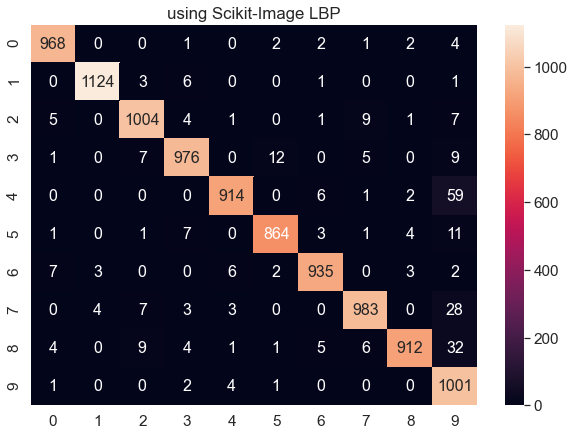

In [12]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']
y_pred = classify_hog(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3a', 'using HOG')
y_pred = classify_shape_desc(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3b', 'using shape desacriptots')
t1 = time.time()
y_pred = classify_your_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for your LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3c', 'using your LBP')
t1 = time.time()
y_pred = classify_skimage_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for Scikit-Image LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3d', 'using Scikit-Image LBP')

# PART 4

#### Use shape and geometrical features to classify two kinds of leaves.

Here is for your helper functions(optional)

In [ ]:
gray = cv2.thres

Implement your code here.

In [160]:
import imutils
def classify_leaf(image):
    '''
    Classifies the input image to only two classes of leaves.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        int: The class of the image. 1 == apple, 0 == linden
    '''
    
    leaf_type = 0
    dst_image = image.copy()

    #Write your code here
    blur_image = cv2.GaussianBlur(image,(21,21), 5)
    hsv_Image = cv2.cvtColor(blur_image, cv2.COLOR_BGR2HSV)
    lower = np.array([35, 50, 0], dtype="uint8")
    upper = np.array([85, 255, 255], dtype="uint8")
    mask = cv2.inRange(hsv_Image, lower, upper)
    green_image = cv2.bitwise_and(blur_image,blur_image, mask= mask)
    gray = cv2.cvtColor(green_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=len)
    (x,y), (ma,MA), angle = cv2.fitEllipse(cnt)
    eccentricity = np.sqrt(1 - (ma / MA)**2)
    print("e: ", eccentricity)
    if eccentricity > 0.7:
        leaf_type = 1
    else:
        leaf_type = 0

    return leaf_type

Test your implementation (don't change this cell).

e:  0.7716147127062696
e:  0.776727742505656
e:  0.7354417923030598
e:  0.8197018213072973
e:  0.5034133685437017
e:  0.5890728898833614
e:  0.6995199098239013
e:  0.5123522678318825


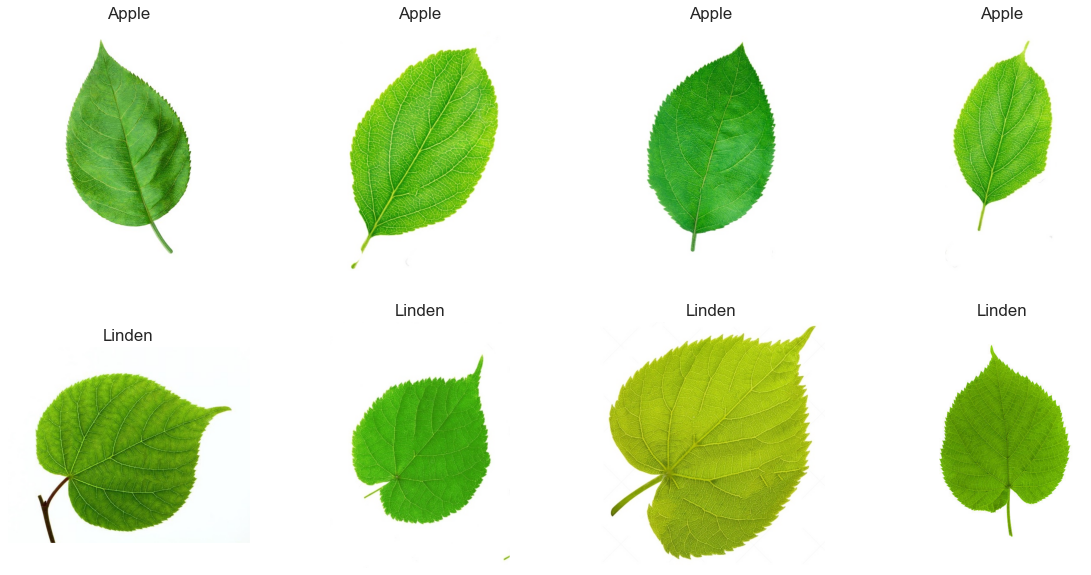

Accuracy is 0.0%


In [161]:
image_list = []
error = 0
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'apple', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    error += int(leaf_type==1) 
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'linden', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    error += int(leaf_type==0) 
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
plotter(image_list, 2, 4, True, 20, 10, '4')
print("Accuracy is {}%".format(100-error/0.08))

To create proper files for sending in the Quera run this cell, please.

In [14]:
!python notebook_converter.py

End!!!